In [0]:
!pip install soundfile
!pip install torchaudio
!pip install librosa
!pip install pesq
!pip install pystoi
import torch

In [0]:
!cd /content/drive/My\ Drive/ && rm -r noisy_wavs

In [0]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import soundfile as sf
import numpy as np
import librosa
import scipy


def convert_audio_to_array(wav_path):
    samples, sample_rate = sf.read(wav_path)
    return samples, sample_rate

# def visualize_spectr(spectr):
#     f, ax = plt.subplots()
#     ax.set_ylim(0, 65)
#     plt.imshow(spectr, cmap='plasma')

def get_spectr_and_phase(signal, norm=False):
    print(signal.shape)       
    signal_length = signal.shape[0]
    n_fft = 512
    y_pad = librosa.util.fix_length(signal, signal_length + n_fft // 2)
    
    F = librosa.stft(y_pad, n_fft=512, hop_length=256, win_length=512, window=scipy.signal.hamming)
    
    Lp=np.abs(F)
    phase=np.angle(F)
    if norm == True:    
        meanR = np.mean(Lp, axis=1).reshape((257,1))
        stdR = np.std(Lp, axis=1).reshape((257,1))+1e-12
        NLp = (Lp-meanR)/stdR
    else:
        NLp=Lp
    
    NLp=np.reshape(NLp.T,(1,NLp.shape[1],257)) # For LSTM

    return NLp, phase, signal_length

(1, 151, 257)


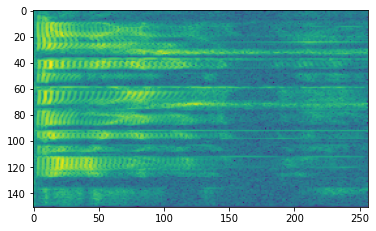

In [0]:
samples, sample_rate = convert_audio_to_array('/content/drive/My Drive/data/lisa/data/timit/raw/TIMIT/TRAIN/DR7/MSAH1/SI1049.WAV')
NLp, phase, signal_length = get_spectr_and_phase(samples)
print(NLp.shape)
plt.imshow(np.log(np.squeeze(NLp, 0) + 1e-20))

NameError: ignored

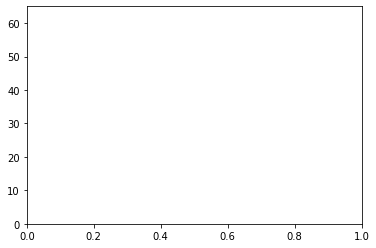

In [0]:
f, ax = plt.subplots()
ax.set_ylim(0, 65)
plt.imshow(np.log(spectr + 1e-10), cmap="plasma")

In [0]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
import glob
import os

In [0]:
def generate_noisy_wavs(path_to_clean_wavs, clean_limit, snrs, path_to_noises, noise_types_wavs, path_to_save):
    clean_wavs = glob.glob(os.path.join(path_to_clean_wavs, '**/*.WAV'), recursive=True)[:10]
    print(clean_wavs)
    for clean_wav_path in clean_wavs:
        wav_name = clean_wav_path.rsplit('/', 1)[-1].strip('.WAV')
        if not os.path.exists(os.path.join(path_to_save, wav_name)):
            os.mkdir(os.path.join(path_to_save, wav_name))
        clean_wav, sample_rate = sf.read(clean_wav_path)
        rms_signal = np.mean(clean_wav**2)**(1/2)
        #print(clean_wav.shape)
        for snr in snrs:
            for noise_type_wav in noise_types_wavs:
                noise_type_wav = os.path.join(path_to_noises, noise_type_wav)
                noise_name = noise_type_wav.rsplit('/', 1)[-1].strip('.wav')
                noise_wav, sample_rate = sf.read(noise_type_wav)
                rms_noise = np.mean(noise_wav**2)**(1/2)
                rms_noise_should = (rms_signal**2/(10**(snr/10)))**(1/2)
                noise = noise_wav * (rms_noise_should/rms_noise)
                noise_wav = clean_wav + np.concatenate([noise, noise, noise, noise, noise, noise, noise])[:clean_wav.shape[0]]
                #print(noise_wav.shape)
                sf.write(os.path.join(path_to_save, wav_name, 'snr_{}_noise_{}.wav'.format(str(snr), noise_name)), noise_wav, sample_rate)

In [0]:
generate_noisy_wavs('/content/drive/My Drive/test_model_data/', 10, [-4, 0, 4], '/content/drive/My Drive/Nonspeech', ['n1.wav', 'n2.wav', 'n3.wav'],
                    '/content/drive/My Drive/noisy_wavs/')

['/content/drive/My Drive/test_model_data/SA2.WAV', '/content/drive/My Drive/test_model_data/SX127.WAV', '/content/drive/My Drive/test_model_data/SX217.WAV', '/content/drive/My Drive/test_model_data/SI1657.WAV', '/content/drive/My Drive/test_model_data/SX37.WAV', '/content/drive/My Drive/test_model_data/SI1027.WAV', '/content/drive/My Drive/test_model_data/SA1.WAV', '/content/drive/My Drive/test_model_data/SI648.WAV']


(1, 188, 257)


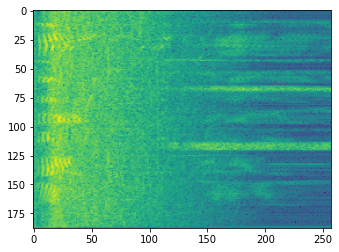

In [0]:
samples, sample_rate = convert_audio_to_array('/content/drive/My Drive/noisy_wavs/SX115/snr_4_noise_n1.wav')
NLp, phase, signal_length = get_spectr_and_phase(samples)
print(NLp.shape)
plt.imshow(np.log(np.squeeze(NLp, 0) + 1e-20))

In [0]:
class Timit(Dataset):

    def __init__(self, path_to_clean, path_to_noisy):
        
        self.clean_paths = glob.glob(os.path.join(path_to_clean, '**/*.WAV'), recursive=True)
        print(len(self.clean_paths))
        self.amount_noisy = len(glob.glob(os.path.join(path_to_noisy, '**/*.wav'), recursive=True))
        print(self.amount_noisy)
        self.every = self.amount_noisy // len(self.clean_paths)
        self.path_to_noisy = path_to_noisy
    
    def __len__(self):
        return self.amount_noisy

    def __getitem__(self, idx):
        
        clean_audio_path = self.clean_paths[idx // self.every]
        clean_wav_name = clean_audio_path.rsplit('/')[-1].strip('.WAV')

        folder_path = os.path.join(self.path_to_noisy, clean_wav_name)
        noisy_audio_path = os.path.join(folder_path, os.listdir(folder_path)[idx % self.every])

        noisy_array, sample_rate = convert_audio_to_array(noisy_audio_path)
        spectr_noisy, _, _ = get_spectr_and_phase(noisy_array, norm=True)
        spectr_noisy = np.squeeze(spectr_noisy, 0)
        
        array, sample_rate = convert_audio_to_array(clean_audio_path)
        spectr, _, _ = get_spectr_and_phase(array, norm=True)
        spectr = np.squeeze(spectr, 0)


        return {'clean': spectr, 'noisy': spectr_noisy, '1d_array_len': array.shape[0], 'sample_rate': sample_rate}

In [0]:
train_dataset = Timit('/content/drive/My Drive/data/lisa/data/timit/raw/TIMIT/TRAIN/', '/content/drive/My Drive/noisy_wavs/')

4620
90


In [0]:
train_dataset = Timit('/content/drive/My Drive/test_model_data/', '/content/drive/My Drive/noisy_wavs/')

8
72


In [0]:
train_dataset[0]

(34509,)
(34509,)


{'1d_array_len': 34509,
 'clean': array([[ 1.4430002 ,  0.28821254, -0.33580273, ..., -0.4437435 ,
         -0.2956597 , -0.26996797],
        [ 1.5795511 ,  0.16263025, -0.29007906, ..., -0.39583814,
         -0.27545986, -0.2612593 ],
        [ 2.323084  ,  1.3671248 , -0.57673585, ..., -0.4543514 ,
         -0.30535454, -0.27736703],
        ...,
        [ 1.3695273 ,  0.49294737, -0.8760818 , ..., -0.42870045,
         -0.30868605, -0.2625791 ],
        [ 0.5055968 , -0.51276654,  0.2473911 , ..., -0.39097577,
         -0.3141675 , -0.25003028],
        [-0.7085183 , -0.53343666, -0.49181986, ..., -0.45844918,
         -0.3165394 , -0.28224722]], dtype=float32),
 'noisy': array([[ 2.6409197 ,  2.0422962 ,  2.7250779 , ..., -0.3964337 ,
         -0.31851408, -0.28393057],
        [ 3.0534246 , -0.2761957 , -1.5337214 , ..., -0.34440967,
         -0.3090471 , -0.22371922],
        [-0.13230573, -0.11371977, -0.5901085 , ..., -0.4300768 ,
         -0.3056646 , -0.26047957],
        ..

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class LstmGen(nn.Module):


    def __init__(self, input_features, hidden_dim, num_layers, fc_hidden_dim):
        super(LstmGen, self).__init__()

        self.lstm = nn.LSTM(input_features, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, fc_hidden_dim)
        self.fc2 = nn.Linear(fc_hidden_dim, input_features)

    def forward(self, x):
        inputs = x
        x, _ = self.lstm(x)
        x = F.leaky_relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return inputs * x

In [0]:
#Delete padding?
class ConvDiscriminator(nn.Module):

    def __init__(self):
        super(ConvDiscriminator, self).__init__()

        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels=2, out_channels=15,
                                                      kernel_size=(5, 5), padding=(2, 2)))
        
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(in_channels=15, out_channels=25,
                                                      kernel_size=(7, 7), padding=(3, 3)))
        
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels=25, out_channels=40,
                                                      kernel_size=(9, 9), padding=(4, 4)))
        
        self.conv4 = nn.utils.spectral_norm(nn.Conv2d(in_channels=40, out_channels=50,
                                                      kernel_size=(11, 11), padding=(5, 5)))
        
        self.fc1 = nn.utils.spectral_norm(nn.Linear(50, 50))
        self.fc2 = nn.utils.spectral_norm(nn.Linear(50, 10))
        self.fc3 = nn.utils.spectral_norm(nn.Linear(10, 1))
    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.shape[0], -1)

        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return x

In [0]:
from pesq import pesq
from pystoi import stoi

def Q(mode, clean, denoised, sr):
    if mode == "pesq":
        #Figure out wb and nb what is it
        return pesq(sr, clean, denoised, 'wb')
    elif mode == "stoi":
        return stoi(clean, denoised, sr, extended=False)

In [0]:
class MetricGan(nn.Module):


    def __init__(self, input_features, hidden_dim, num_layers, fc_hidden_dim, metric):
        super(MetricGan, self).__init__()
        self.G = LstmGen(input_features, hidden_dim, num_layers, fc_hidden_dim)
        self.D = ConvDiscriminator()
        self.metric = metric
    
    def forward(self, noisy):
        denoised = self.G(noisy)
        return denoised
    
    def backward_G(self, batch):
        denoised = self.forward(batch["noisy"])
        logits = self.D(torch.stack([denoised, batch["clean"]], dim=1))
        #Magical number 2
        loss = torch.sum((logits - 2)**2)
        loss.backward()

        return loss

    def backward_D(self, batch):

        denoised = self.forward(batch["noisy"])
        logits_noise = self.D(torch.stack([denoised, batch["clean"]], dim=1))
        logits_clean = self.D(torch.stack([batch["clean"], batch["clean"]], dim=1))

        denoised_1d = librosa.istft(denoised.squeeze(0).detach().numpy().transpose(), length=batch['1d_array_len'])
        clean_1d = librosa.istft(batch["clean"].squeeze(0).detach().numpy().transpose(), length=batch['1d_array_len'])

        metrics_noise = Q(self.metric, clean_1d, denoised_1d, batch['sample_rate'])
        metrics_clean = Q(self.metric, clean_1d, denoised_1d, batch['sample_rate'])

        loss = (logits_noise - metrics_noise)**2 + (logits_clean.item() - metrics_clean)**2
        loss.backward()

        return loss.item()

In [0]:
#train_dataset = Timit('/content/drive/My Drive/data/lisa/data/timit/raw/TIMIT/TRAIN/', '/content/drive/My Drive/noisy_wavs/')
train_dataloader = DataLoader(train_dataset, batch_size=1)

In [0]:
model = MetricGan(257, 200, 2, 300, "pesq")
for idx, batch in enumerate(train_dataloader):
    print(batch["noisy"].shape)
    model(batch["noisy"])
    model.backward_G(batch)
    model.backward_D(batch)
    break

(34509,)
(34509,)
torch.Size([1, 136, 257])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [0]:
model = ConvDiscriminator()
a = torch.randn((1, 2, 500, 257))
print(model(a))

tensor([[0.1368]], grad_fn=<LeakyReluBackward0>)


In [0]:
model = LstmGen(257, 200, 2, 300)
a = torch.randn((1, 500, 257))
print(model(a))

torch.Size([1, 500, 257])
tensor([[[-0.1064,  0.4138, -0.5203,  ..., -0.2862,  0.4930,  0.2462],
         [-0.6437, -0.3689,  0.4594,  ..., -1.3059, -0.2234, -0.1268],
         [ 0.3167,  0.2280,  0.6659,  ..., -0.3588, -1.1962,  0.0530],
         ...,
         [-0.1406, -0.4838,  0.5866,  ..., -0.0838, -0.3212, -0.1926],
         [ 0.4460,  0.2980,  0.3596,  ..., -0.1922,  0.2214,  0.6185],
         [-0.7150, -0.3507, -0.1651,  ..., -0.3028, -0.5590,  0.5683]]],
       grad_fn=<MulBackward0>)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [0]:
for idx, batch in enumerate(train_dataloader):
    print(idx, batch)
    if idx == 5:
        break

0 {'clean': tensor([[[[-0.3018, -0.7264, -0.8602,  ..., -0.3548, -0.2422, -0.1342],
          [-0.2557, -0.5762, -0.6686,  ..., -0.3782, -0.4959, -0.5658],
          [-0.0405, -0.3751, -0.7270,  ..., -0.4051, -0.3583, -0.3090],
          ...,
          [-0.3149, -0.8471,  0.2693,  ..., -0.3685, -0.3921, -0.5349],
          [-0.3645,  0.3681,  0.2477,  ..., -0.2772, -0.3765, -0.4141],
          [-1.3124, -0.9292, -0.7652,  ..., -0.4883, -0.5315, -0.5235]]]]), 'noisy': tensor([[[[9.9944e-02, 1.5714e-01, 1.6217e-01,  ..., 1.2355e-03,
           1.3801e-03, 1.5437e-03],
          [8.3299e-02, 6.6897e-02, 2.5280e-02,  ..., 1.3239e-03,
           1.3791e-03, 9.8072e-05],
          [4.0976e-02, 7.6795e-02, 5.7424e-02,  ..., 2.8318e-04,
           2.7934e-04, 1.8911e-03],
          ...,
          [6.9777e-02, 1.2769e-01, 1.1584e-01,  ..., 1.6614e-03,
           1.5241e-03, 9.0418e-04],
          [1.9427e-02, 5.3267e-02, 7.5856e-02,  ..., 3.9795e-03,
           3.6124e-03, 4.5446e-03],
        